Primero se importan las bibliotecas y funcionalidades necesarias:
pandas para dataframes

re para limpiar texto

sklearn para realizar el modelo

matplotlib y seaborn para los plots

wordcloud para los gráficos de nubes de palabras

ast y json debido a la naturaleza de la base de datos

nltk para limpiar palabras ruido

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Para esta tarea utilizo la tabla "movies_metadata.csv" de la base de datos "Movies Dataset" disponible en https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


El propósito es poder predecir el género de una película dado el plot, esta base de datos es bastante grande y veamos qué es lo que tiene: primero guardamos la base de datos en un dataframe llamado data

In [2]:
data = pd.read_csv("movies_metadata.csv", low_memory=False)

In [3]:
data.columns


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

La base de datos contiene varias columnas de información pero sólo nos interesa: géneros, título y resumen:

In [4]:
data = data[["genres", "original_title", "overview"]]

La columna géneros tiene un array de jsons ya que una película puede tener varios géneros, para limpiar esta columna borramos los json y nos quedamos con los valores del atributo "name", es decir con los géneros

In [5]:
print(data.head())

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  
0  Led by Woody, Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on, mistreated and stepped on, the wom...  
4  Just when George Banks has recovered from his ...  


In [6]:
data['genres'] = data['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])


In [7]:
print(data.head())

                         genres               original_title  \
0   [Animation, Comedy, Family]                    Toy Story   
1  [Adventure, Fantasy, Family]                      Jumanji   
2             [Romance, Comedy]             Grumpier Old Men   
3      [Comedy, Drama, Romance]            Waiting to Exhale   
4                      [Comedy]  Father of the Bride Part II   

                                            overview  
0  Led by Woody, Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on, mistreated and stepped on, the wom...  
4  Just when George Banks has recovered from his ...  


In [8]:
data['genres'] = data['genres'].apply(lambda x: x[0] if x else None)


Ahora nos quedamos sólo con el primer elemento del array de género para poder evitar predicciones cruzadas

In [9]:
print(data.head())

      genres               original_title  \
0  Animation                    Toy Story   
1  Adventure                      Jumanji   
2    Romance             Grumpier Old Men   
3     Comedy            Waiting to Exhale   
4     Comedy  Father of the Bride Part II   

                                            overview  
0  Led by Woody, Andy's toys live happily in his ...  
1  When siblings Judy and Peter discover an encha...  
2  A family wedding reignites the ancient feud be...  
3  Cheated on, mistreated and stepped on, the wom...  
4  Just when George Banks has recovered from his ...  


Veamos cuántos elementos tiene cada género para poder elegir un subconjunto de géneros para hacer el modelo:

In [10]:
genre_counts = data["genres"].value_counts()
print(genre_counts)


genres
Drama                   11966
Comedy                   8820
Action                   4489
Documentary              3415
Horror                   2619
Crime                    1685
Thriller                 1665
Adventure                1514
Romance                  1191
Animation                1124
Fantasy                   704
Science Fiction           647
Mystery                   554
Family                    524
Music                     487
Western                   451
TV Movie                  390
War                       379
History                   279
Foreign                   118
Carousel Productions        1
Aniplex                     1
Odyssey Media               1
Name: count, dtype: int64


Por la cantidad de elementos decidí quedarme con: Documentales, horror, crimen, thriller y romance


In [11]:
desired_genres = ['Documentary', 'Horror', 'Crime', 'Thriller', 'Romance']
data = data[data['genres'].isin(desired_genres)]

In [12]:
data.reset_index(drop=True, inplace=True)
print(data.head())

    genres                    original_title  \
0  Romance                  Grumpier Old Men   
1    Crime                        Four Rooms   
2    Crime    Ace Ventura: When Nature Calls   
3  Romance  Guillaumet, les ailes du courage   
4    Crime                             Se7en   

                                            overview  
0  A family wedding reignites the ancient feud be...  
1  It's Ted the Bellhop's first night on the job....  
2  Summoned from an ashram in Tibet, Ace finds hi...  
3                                                NaN  
4  Two homicide detectives are on a desperate hun...  


In [13]:
data = data.copy()
data.dropna(subset=['overview'], inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.head())

     genres                  original_title  \
0   Romance                Grumpier Old Men   
1     Crime                      Four Rooms   
2     Crime  Ace Ventura: When Nature Calls   
3     Crime                           Se7en   
4  Thriller                Le confessionnal   

                                            overview  
0  A family wedding reignites the ancient feud be...  
1  It's Ted the Bellhop's first night on the job....  
2  Summoned from an ashram in Tibet, Ace finds hi...  
3  Two homicide detectives are on a desperate hun...  
4  The year is 1952, in Quebec City. Rachel (16),...  


In [14]:
#nltk.download('stopwords')
#nltk.download('punkt')

Ahora limpiamos la columan overview: quitamos palabras ruido consideradas por la biblioteca nltk

In [15]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [16]:
data['cleaned_overview'] = data['overview'].apply(clean_text)


In [17]:
print(data[['overview', 'cleaned_overview']].head())

                                            overview  \
0  A family wedding reignites the ancient feud be...   
1  It's Ted the Bellhop's first night on the job....   
2  Summoned from an ashram in Tibet, Ace finds hi...   
3  Two homicide detectives are on a desperate hun...   
4  The year is 1952, in Quebec City. Rachel (16),...   

                                    cleaned_overview  
0  family wedding reignites ancient feud next-doo...  
1  's Ted Bellhop 's first night job ... hotel 's...  
2  Summoned ashram Tibet , Ace finds perilous jou...  
3  Two homicide detectives desperate hunt serial ...  
4  year 1952 , Quebec City . Rachel ( 16 ) , unma...  


Ya no hay palabras ruido pero aún hay caracteres que pueden causar problemas, quitamos entonces todos los caracteres especiales y palabras con una sola letra

In [18]:
def clean_text2(text):
    text = re.sub(r'[^\w\s]', '', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\bs\s\b', '', text)
    return text

In [19]:
data['cleaned_overview'] = data['cleaned_overview'].apply(clean_text2)

In [20]:
print(data[['overview', 'cleaned_overview']].head())

                                            overview  \
0  A family wedding reignites the ancient feud be...   
1  It's Ted the Bellhop's first night on the job....   
2  Summoned from an ashram in Tibet, Ace finds hi...   
3  Two homicide detectives are on a desperate hun...   
4  The year is 1952, in Quebec City. Rachel (16),...   

                                    cleaned_overview  
0  family wedding reignites ancient feud nextdoor...  
1  ted bellhop first night job hotel unusual gues...  
2  summoned ashram tibet ace finds perilous journ...  
3  two homicide detectives desperate hunt serial ...  
4  year 1952 quebec city rachel 16 unmarried preg...  


# A entrenar el modelo!!!!

In [21]:
X=data['cleaned_overview']
y=data['genres']

Ahora con el modelo asignamos dos cosas: el objetivo a predecir que son los géneros y el atributo para entrenar que son las descripciones

In [22]:
cleaned_genre_counts = data["genres"].value_counts()
print(cleaned_genre_counts)

genres
Documentary    3376
Horror         2612
Crime          1663
Thriller       1646
Romance        1163
Name: count, dtype: int64


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Se divide entonces el modelo en conjuntos de entrenamiento y prueba. Con la funcion vectorizer se generará la bolsa de palabras con la que se harán las predicciones

In [24]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [25]:
model = MultinomialNB()
model.fit(X_train_bow, y_train)

MultinomialNB()

Veamos entonces la matriz de confusión:

In [26]:
y_pred = model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.6634799235181644
Confusion Matrix:
[[155  34  65  16  71]
 [  6 617  15   6   9]
 [ 16  23 459   3  34]
 [ 22  43  52  83  29]
 [ 70  32 151   7  74]]


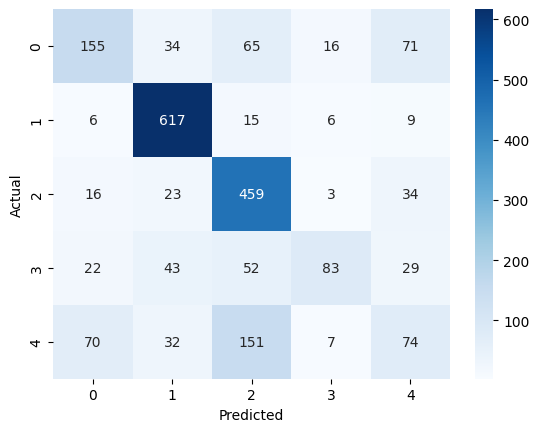

In [27]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
grouped_data = data.groupby('genres')['cleaned_overview'].apply(' '.join).reset_index()

genre_text_dict = {genre: text for genre, text in zip(grouped_data['genres'], grouped_data['cleaned_overview'])}

Con ayuda de la biblioteca WordCloud podemos inferir de manera visual cuánto aporta cada palabra a los géneros que pretendemos predecir:

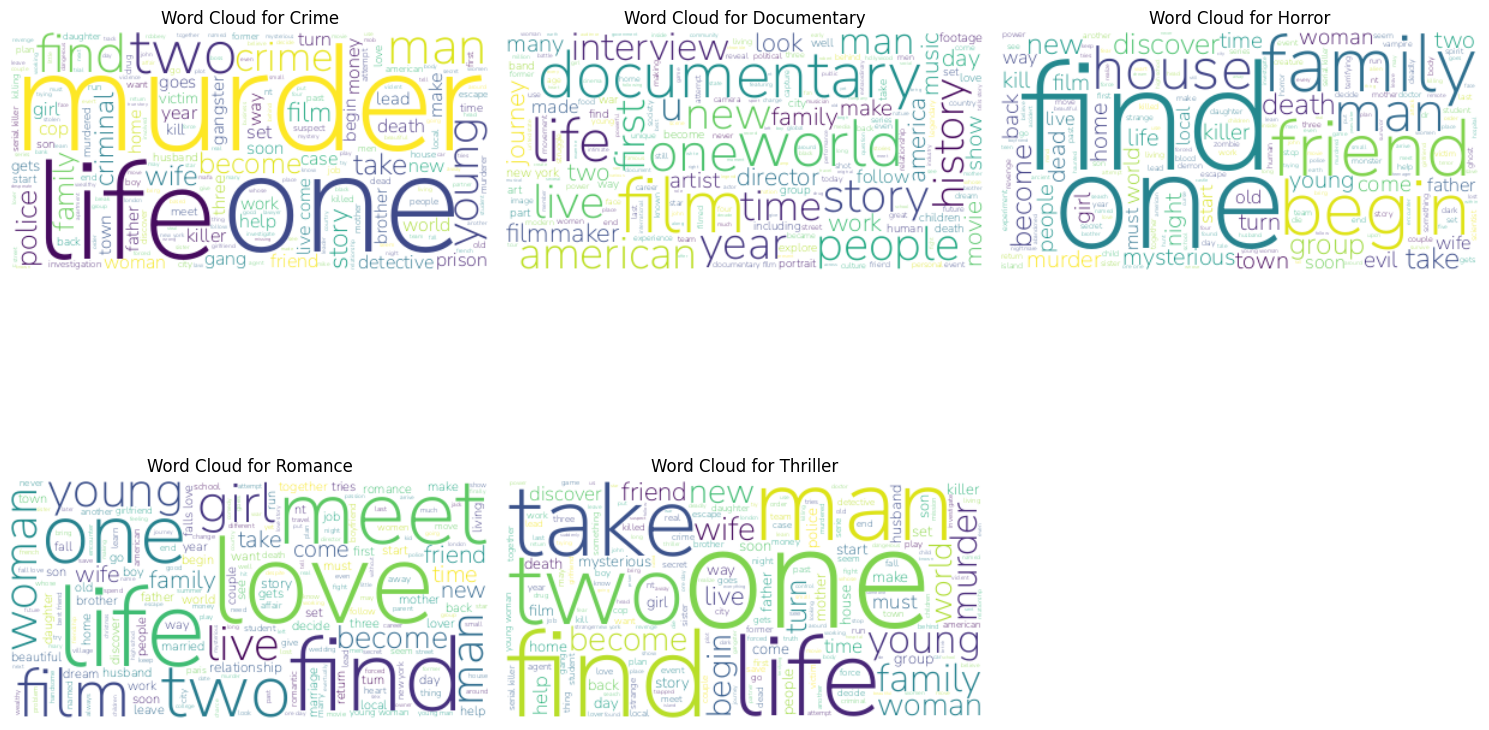

In [32]:
genre_text_dict = {genre: text for genre, text in zip(grouped_data['genres'], grouped_data['cleaned_overview'])}
genres = grouped_data['genres'].unique()

num_rows = 2
num_cols = 3


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i, genre in enumerate(genres):
    text = genre_text_dict[genre]
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    wordcloud = WordCloud(width=400, height=200, background_color='white', font_path="NunitoSans-VariableFont_YTLC,opsz,wdth,wght.ttf").generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'WordCloud del género: {genre}')
    ax.axis('off')

# Ocultar subplots vacíos
for i in range(len(genres), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# A guardar el modelo para probarlo con nuevas descripciones

In [36]:
from joblib import dump
from joblib import load

In [35]:
dump(model, 'modelo_clasificacion.joblib')
dump(vectorizer, 'vectorizador_bow.joblib')

['vectorizador_bow.joblib']

probamos primero con un elemento de la base de datos: la linea 456 del dataframe corresponde a la película "la hija del general" que es una película de crimen. Esta información no la conoce el modelo

In [38]:
fila_456 = data.iloc[456]
print(fila_456)

genres                                                          Crime
original_title                                 The General's Daughter
overview            When the body of Army Capt. Elizabeth Campbell...
cleaned_overview    body army capt elizabeth campbell found georgi...
Name: 456, dtype: object


cargar el modelo


In [39]:
model = load('modelo_clasificacion.joblib')
vectorizer = load('vectorizador_bow.joblib')

damos la información a la bolsa de palabras para ver qué es lo que predice

In [42]:
texto_prueba = [fila_456['overview']]
texto_prueba_bow = vectorizer.transform(texto_prueba)

In [44]:

etiqueta_predicha = model.predict(texto_prueba_bow)


print("Etiqueta predicha:", etiqueta_predicha[0])

Etiqueta predicha: Crime


Probamos ahora con un nuevo plot: La película Scream2 que está categorizada como Crimen y Horror. El modelo debería arrojar alguna de estas dos opciones

In [59]:
# Proporcionar un nuevo texto de prueba para predecir
texto_de_prueba = ["Two Windsor College seniors, Maureen Evans and Phil Stevens, attend a sneak preview of Stab, a film based on the events of the Woodsboro massacre.[a] Briefly exiting the theater to use the bathroom, Phil is killed by the masked killer now known as Ghostface. Ghostface sits beside Maureen in  place and stabs her repeatedly, unnoticed by the raucous crowd, leading her to climb up on stage in a cry for help, which the audience mistakes for a publicity stunt until she falls dead."]
texto_de_prueba_bow = vectorizer.transform(texto_de_prueba)


etiqueta_predicha2 = model.predict(texto_de_prueba_bow)


print("Etiqueta predicha:", etiqueta_predicha2[0])

Etiqueta predicha: Crime


El modelo predijo adecuadamente uno de los géneros.